In [1]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot

In [1]:
import os
import cv2
import math
import keras
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

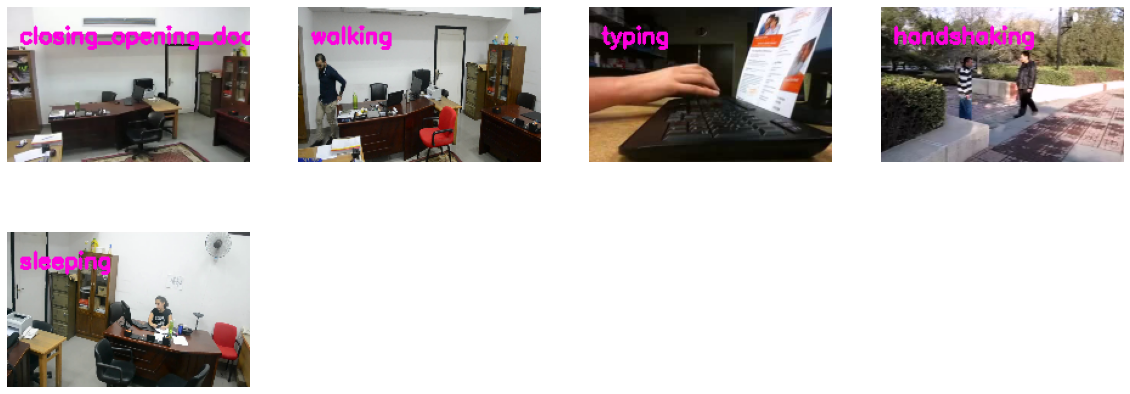

In [13]:
plt.figure(figsize=(20,20))

all_class=os.listdir('/home/isfcr/Desktop/cap/DATA')

l=list(range(len(all_class)))

for counter,index in enumerate(l,1):
  class_name=all_class[index]

  video_files_names_list = os.listdir(f'/home/isfcr/Desktop/cap/DATA/{class_name}')
  
  selected_video_file_name = random.choice(video_files_names_list)

  video_reader = cv2.VideoCapture(f'/home/isfcr/Desktop/cap/DATA/{class_name}/{selected_video_file_name}')

  _, bgr_frame = video_reader.read()

  video_reader.release()

  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    
  resized_frame = cv2.resize(rgb_frame, (200, 128))

  cv2.putText(resized_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 223), 2)
    
  plt.subplot(5, 4, counter);plt.imshow(resized_frame);plt.axis('off')

In [5]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 50

DATASET_DIR = "C:/Users/abhir/Desktop/cap-2-esa/data"

CLASSES_LIST = ["closing_opening_door","walking","typing","handshaking","sleeping"]

In [15]:
def frames_extraction(video_path):

    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
        
        frames_list.append(normalized_frame)
     
    video_reader.release()

    return frames_list

In [16]:
def create_dataset():
    
    features = []
    labels = []
    video_files_paths = []
    count=0

    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting Data of Class: {class_name}')
        
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            frames = frames_extraction(video_file_path)

            if len(frames) == SEQUENCE_LENGTH:

                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
            
            else: 
                count=count+1

    features = np.asarray(features)
    labels = np.array(labels)  
    
    
    return features, labels, video_files_paths

In [17]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: closing_opening_door
Extracting Data of Class: walking
Extracting Data of Class: typing
Extracting Data of Class: handshaking
Extracting Data of Class: sleeping


In [9]:
# features.lengnth = total number of videos
# features[0].length=number of frames
# features[0][0] and features[0][0][0] = 64 X 64 features matrix

In [18]:
one_hot_encoded_labels = to_categorical(labels)

In [19]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.3, shuffle = True,
                                                                            random_state = seed_constant)

In [20]:
def create_convlstm_model():
    
    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    model.summary()
    
    return model

In [12]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!!!!!!!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 30, 62, 62, 4)     1024      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 31, 31, 4)     0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 31, 31, 4)     0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 30, 29, 29, 8)     3488      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 30, 15, 15, 8)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 15, 15, 8)     0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 30, 13, 13, 14)    1

In [13]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2, 
                                                     callbacks = [early_stopping_callback])

Epoch 1/30
47/47 [==============================] - 52s 864ms/step - loss: 1.5619 - accuracy: 0.3925 - val_loss: 1.4032 - val_accuracy: 0.4468
Epoch 2/30
47/47 [==============================] - 44s 931ms/step - loss: 1.0808 - accuracy: 0.5376 - val_loss: 1.1407 - val_accuracy: 0.5106
Epoch 3/30
47/47 [==============================] - 43s 905ms/step - loss: 0.9355 - accuracy: 0.5753 - val_loss: 1.0843 - val_accuracy: 0.5532
Epoch 4/30
47/47 [==============================] - 40s 850ms/step - loss: 0.7865 - accuracy: 0.6559 - val_loss: 1.0330 - val_accuracy: 0.5319
Epoch 5/30
47/47 [==============================] - 40s 848ms/step - loss: 0.6910 - accuracy: 0.7419 - val_loss: 0.9482 - val_accuracy: 0.5106
Epoch 6/30
47/47 [==============================] - 40s 849ms/step - loss: 0.6367 - accuracy: 0.6828 - val_loss: 0.8814 - val_accuracy: 0.5106
Epoch 7/30
47/47 [==============================] - 40s 849ms/step - loss: 0.5665 - accuracy: 0.7473 - val_loss: 0.9996 - val_accuracy: 0.5745

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

In [15]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

In [21]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

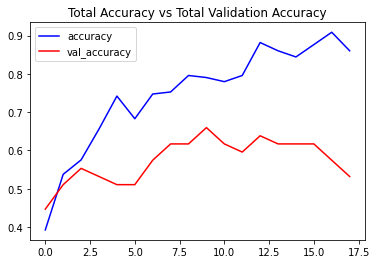

In [19]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

In [23]:
def create_LRCN_model():
   
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [24]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!!!!")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 50, 64, 64, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 50, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 50, 16, 16, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 50, 16, 16, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 50, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 50, 4, 4, 32)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 50, 4, 4, 64)      1

In [25]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 40, mode = 'min', restore_best_weights = True)
 
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.3, callbacks = [early_stopping_callback])

Epoch 1/70
77/77 [==============================] - 13s 150ms/step - loss: 1.6198 - accuracy: 0.2328 - val_loss: 1.5995 - val_accuracy: 0.2061
Epoch 2/70
77/77 [==============================] - 11s 138ms/step - loss: 1.5335 - accuracy: 0.2951 - val_loss: 1.2625 - val_accuracy: 0.3740
Epoch 3/70
77/77 [==============================] - 10s 134ms/step - loss: 1.2658 - accuracy: 0.3770 - val_loss: 1.1169 - val_accuracy: 0.4275
Epoch 4/70
77/77 [==============================] - 10s 133ms/step - loss: 1.1163 - accuracy: 0.4918 - val_loss: 1.0316 - val_accuracy: 0.4580
Epoch 5/70
77/77 [==============================] - 10s 134ms/step - loss: 1.0024 - accuracy: 0.5148 - val_loss: 1.0073 - val_accuracy: 0.4809
Epoch 6/70
77/77 [==============================] - 10s 133ms/step - loss: 0.9481 - accuracy: 0.5213 - val_loss: 1.0438 - val_accuracy: 0.4656
Epoch 7/70
77/77 [==============================] - 10s 134ms/step - loss: 0.8796 - accuracy: 0.5803 - val_loss: 1.0299 - val_accuracy: 0.4427

Epoch 58/70
77/77 [==============================] - 11s 138ms/step - loss: 0.2273 - accuracy: 0.9180 - val_loss: 0.6249 - val_accuracy: 0.7481
Epoch 59/70
77/77 [==============================] - 10s 136ms/step - loss: 0.2192 - accuracy: 0.9311 - val_loss: 0.6081 - val_accuracy: 0.7481
Epoch 60/70
77/77 [==============================] - 11s 138ms/step - loss: 0.1674 - accuracy: 0.9574 - val_loss: 0.4644 - val_accuracy: 0.8321
Epoch 61/70
77/77 [==============================] - 11s 137ms/step - loss: 0.1729 - accuracy: 0.9541 - val_loss: 0.5965 - val_accuracy: 0.7710
Epoch 62/70
77/77 [==============================] - 11s 137ms/step - loss: 0.2363 - accuracy: 0.9344 - val_loss: 0.5028 - val_accuracy: 0.7939
Epoch 63/70
77/77 [==============================] - 11s 142ms/step - loss: 0.2158 - accuracy: 0.9180 - val_loss: 0.5292 - val_accuracy: 0.8015
Epoch 64/70
77/77 [==============================] - 11s 144ms/step - loss: 0.2112 - accuracy: 0.9377 - val_loss: 0.3945 - val_accuracy:

In [26]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

6/6 [==============================] - 2s 252ms/step - loss: 0.4931 - accuracy: 0.8617


In [27]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

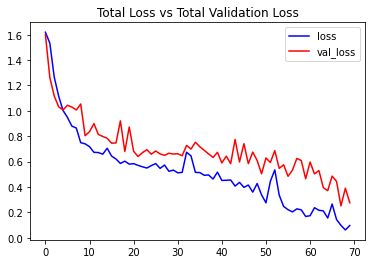

In [28]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

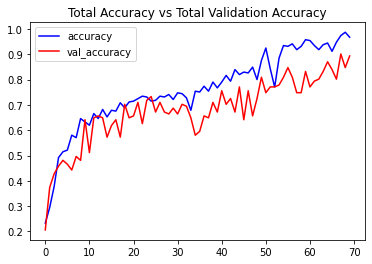

In [29]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [3]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []
    
    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read() 

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        normalized_frame = resized_frame / 255
    
        frames_list.append(normalized_frame)
    
    model=keras.models.load_model("D:/capstone/phase 2/LRCN_model___Date_Time_2022_11_17__15_43_13___Loss_0.4930887520313263___Accuracy_0.8617021441459656.h5")
    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
         
    video_reader.release()

In [13]:
input_video_file_path = f'C:/Users/abhir/Desktop/cap-2-esa/testing/f_014_2 - Copy.mp4'

predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 [==============================] - 1s 626ms/step
Action Predicted: closing_opening_door
Confidence: 0.9908221960067749
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
